## Load libraries

In [1]:
library(tidyverse)
library(Seurat)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




## Load the dataset

In [2]:
# Load Visium spatial transcriptomics data
data_dir <- "../data/spatial/raw_counts/P10_T1_LUAD"

# Load the data using Load10X_Spatial function
visium_data <- Load10X_Spatial(
  data.dir = data_dir,
  filename = "P10_T1_LUAD-filtered_feature_bc_matrix.h5",
  assay = "Spatial",
  slice = "slice1",
  filter.matrix = TRUE
)

# Display the object structure
visium_data

An object of class Seurat 
36601 features across 2200 samples within 1 assay 
Active assay: Spatial (36601 features, 0 variable features)
 1 layer present: counts
 1 spatial field of view present: slice1

## QC and Filtering

**Spatial-specific QC:**
- Remove spots with low gene counts
- Filter spots with high mitochondrial content
- Similar to single-cell QC but for spatial spots

Warning message:
“Default search for "data" layer in "Spatial" assay yielded no results; utilizing "counts" layer instead.”
Warning message:
“The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“`PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“`PackageCheck()` was deprecated in Seura

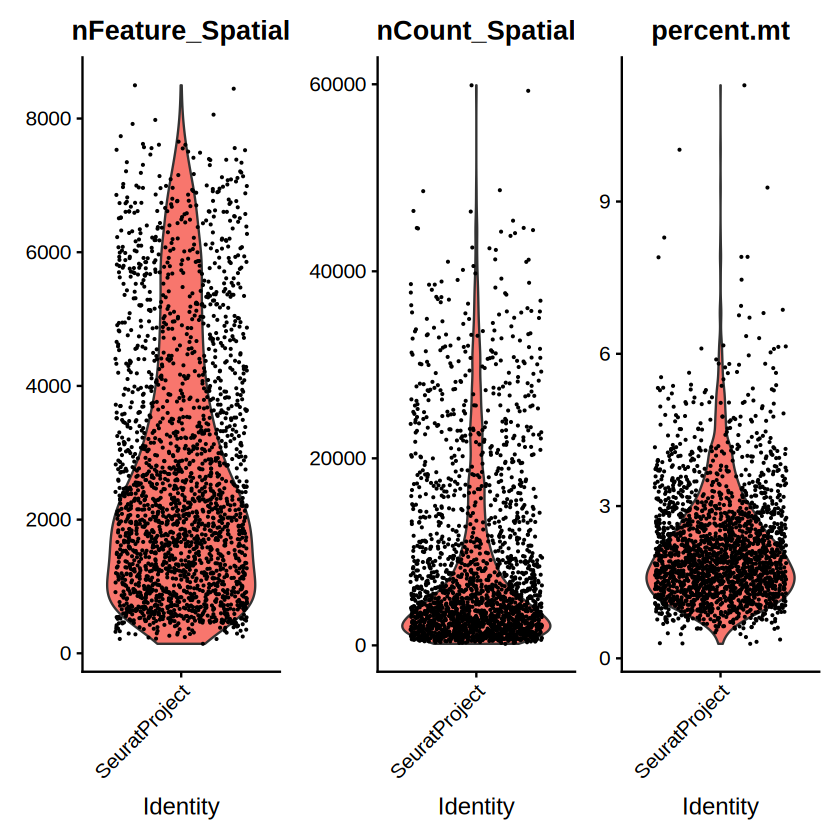

In [3]:
# Calculate mitochondrial QC metrics
visium_data[["percent.mt"]] <- PercentageFeatureSet(visium_data, pattern = "^MT-")

# Visualize QC metrics
VlnPlot(visium_data, features = c("nFeature_Spatial", "nCount_Spatial", "percent.mt"), ncol = 3, pt.size = 0.1)

### Plot the tissue

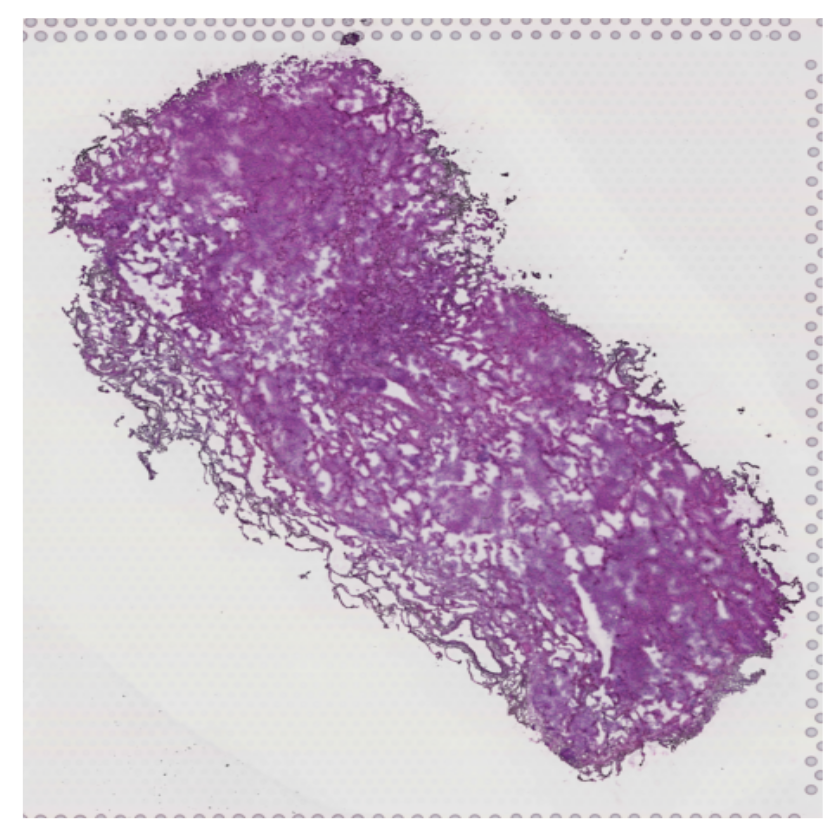

In [33]:
# Spatial visualization showing only tissue (no spots)
SpatialFeaturePlot(visium_data, features = "nCount_Spatial", alpha = c(0, 0)) + theme(legend.position = "right") & NoLegend()

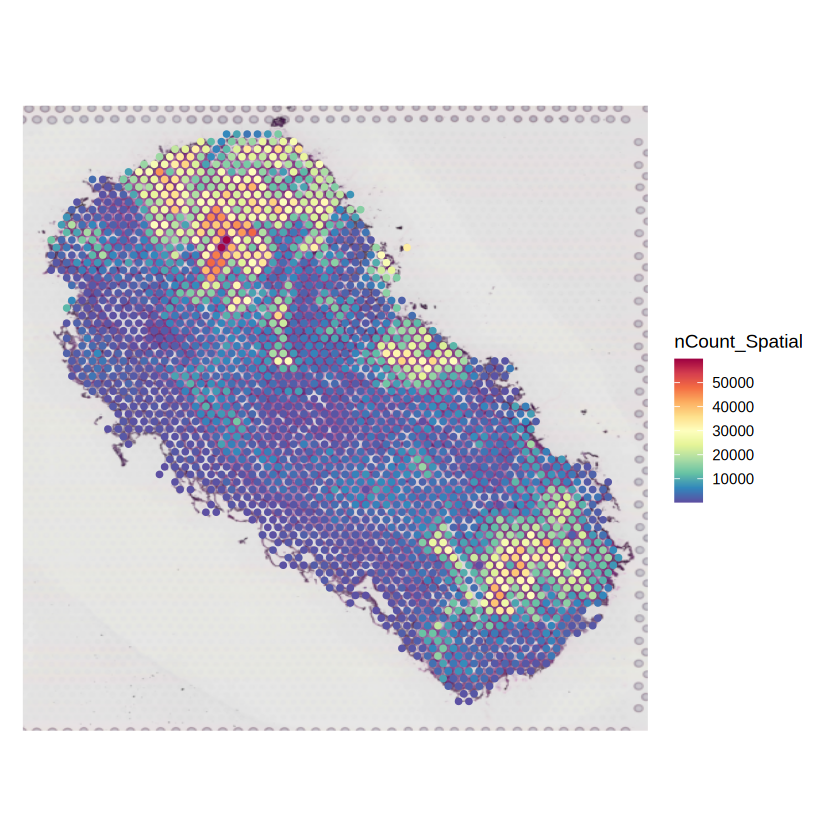

In [4]:
# Spatial visualization of QC metrics
SpatialFeaturePlot(visium_data, features = "nCount_Spatial") + theme(legend.position = "right")

In [5]:
# Filter spots based on QC metrics
visium_data <- subset(visium_data, subset = nFeature_Spatial > 200 & percent.mt < 20)

Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating Seurat objects”
Warning message:
“Not validating Seurat objects”


## Normalization using SCTransform

**SCTransform:**
- Recommended for spatial data
- Normalizes, scales, and finds variable features in one step
- Handles technical variation better than standard LogNormalize

In [6]:
# Normalization with SCTransform
visium_data <- SCTransform(visium_data, assay = "Spatial", verbose = FALSE)

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“The `slot` argument of `SetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“The `slot` argument of `SetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


## Dimensionality Reduction: PCA

**Principal Component Analysis (PCA):**
- Linear technique to reduce dimensionality
- Finds principal components (PCs) that capture the most variance
- Used as input for clustering and visualization
- Here we compute 50 PCs, will use the first 30 for downstream analysis

In [7]:
# Run PCA
visium_data <- RunPCA(visium_data, assay = "SCT", verbose = FALSE)

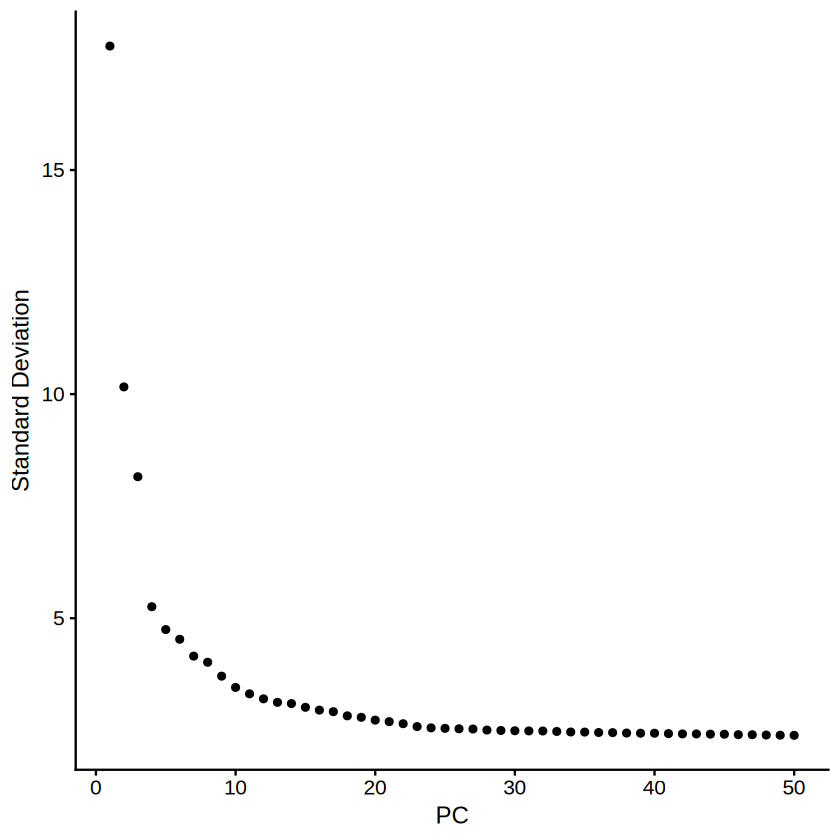

In [8]:
# Visualize PCA - Elbow plot to determine dimensionality
ElbowPlot(visium_data, ndims = 50)

## Clustering: Graph-Based Approach

**Clustering:**
- Groups spots with similar gene expression profiles
- Uses kNN graph construction → community detection (Louvain algorithm)
- Resolution parameter: higher = more clusters, lower = fewer clusters
- Here we use 30 PCs based on elbow plot

In [9]:
# Find neighbors and clusters
visium_data <- FindNeighbors(visium_data, reduction = "pca", dims = 1:30)
visium_data <- FindClusters(visium_data, verbose = FALSE)

Computing nearest neighbor graph

Computing SNN

Computing SNN



## Non-linear Dimensionality Reduction: UMAP

**UMAP (Uniform Manifold Approximation and Projection):**
- Non-linear technique to visualize high-dimensional data in 2D/3D
- Preserves both local and global structure better than PCA
- Spots that are close in UMAP space have similar gene expression
- Used for visualization and exploration

In [10]:
# Run UMAP
visium_data <- RunUMAP(visium_data, reduction = "pca", dims = 1:30)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
22:33:12 UMAP embedding parameters a = 0.9922 b = 1.112

22:33:12 UMAP embedding parameters a = 0.9922 b = 1.112

22:33:12 Read 2199 rows and found 30 numeric columns

22:33:12 Read 2199 rows and found 30 numeric columns

22:33:13 Using Annoy for neighbor search, n_neighbors = 30

22:33:13 Using Annoy for neighbor search, n_neighbors = 30

22:33:13 Building Annoy index with metric = cosine, n_trees = 50

22:33:13 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*


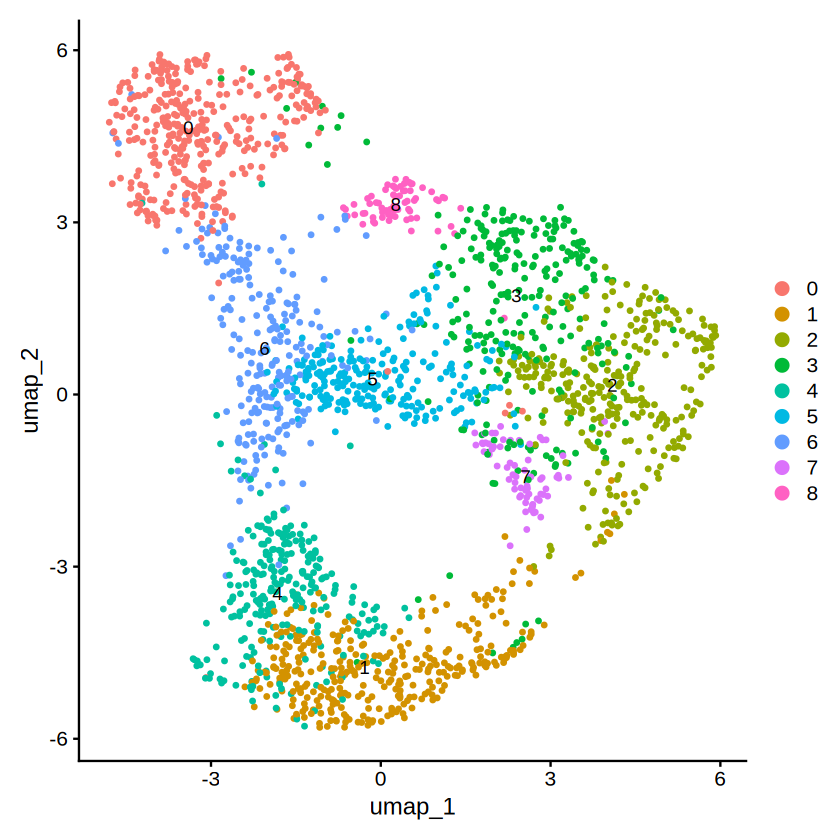

In [11]:
# Visualize clusters in UMAP space
DimPlot(visium_data, reduction = "umap", label = TRUE)

## Spatial Visualization of Clusters

**Spatial Dimension:**
- Unlike single-cell, spatial data has physical location information
- Can visualize clusters overlaid on the tissue image
- Shows spatial organization and regional patterns
- Key advantage: see which cell types/states are where in the tissue

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


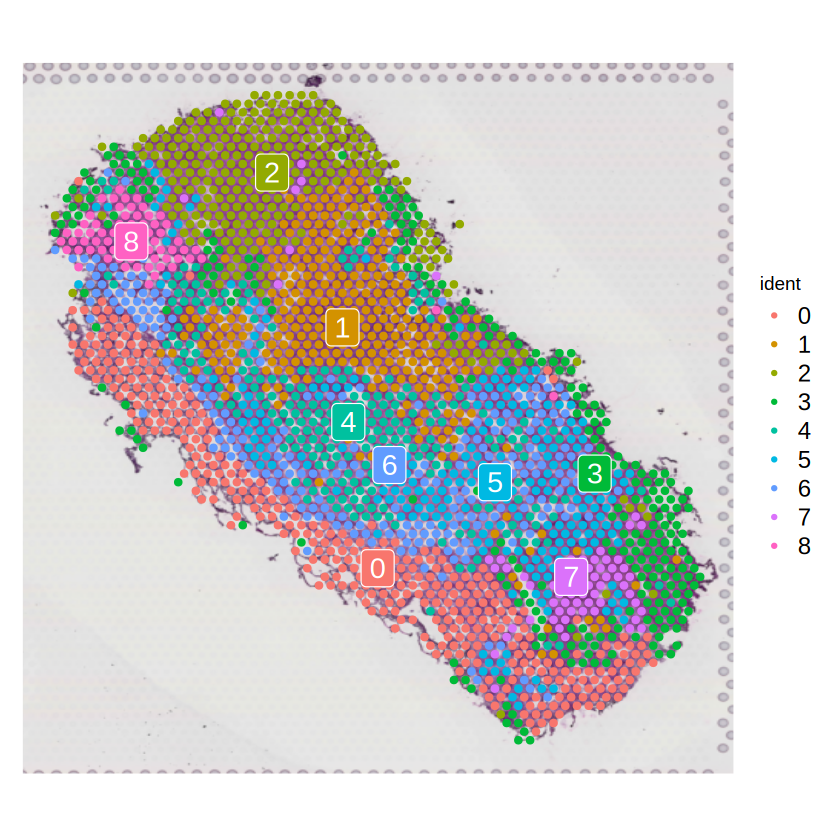

In [38]:
# Visualize clusters on tissue
SpatialDimPlot(visium_data, label = TRUE, label.size = 6) + 
    theme(legend.text = element_text(size = 14))

## Spatially Variable Features: Moran's I

**Moran's I for Spatial Autocorrelation:**
- Measures whether gene expression shows spatial patterns (clustering in space)
- Values range from -1 to 1:
  - Positive: genes are expressed in spatially clustered regions
  - Zero: random spatial distribution
  - Negative: genes alternate in checkerboard pattern
- Identifies genes with spatial organization (e.g., tissue regions, tumor boundaries)
- Key for understanding spatial biology beyond just clustering

In [14]:
# Find spatially variable features using Moran's I
visium_data <- FindSpatiallyVariableFeatures(visium_data, 
                                              assay = "SCT", 
                                              features = VariableFeatures(visium_data)[1:1000],
                                              selection.method = "moransi")

Computing Moran's I

Warning message in dist(x = pos):
“NAs introduced by coercion”
Warning message in dist(x = pos):
“NAs introduced by coercion”


In [15]:
# Get top spatially variable features
top_features <- head(SpatiallyVariableFeatures(visium_data, selection.method = "moransi"), 6)
print(top_features)

Warning message:
“The `selection.method` argument of `SpatiallyVariableFeatures()` is deprecated
as of SeuratObject 5.0.0.
ℹ Please use the `method` argument instead.”


[1] "AC007952.4" "HLA-DRB1"   "COL1A2"     "SFTPC"      "MALAT1"    
[6] "COL1A1"    


In [29]:
# Get the full Moran's I statistics from the SCT assay
moransi_results <- visium_data@assays$SCT@meta.features

# Filter out genes with NA values (only keep genes that were tested)
moransi_results_filtered <- moransi_results[!is.na(moransi_results$MoransI_observed), ]

# Sort by Moran's I observed value (descending)
moransi_results_filtered <- moransi_results_filtered[order(-moransi_results_filtered$MoransI_observed), ]

# Display statistics summary
print(paste("Total genes tested:", nrow(moransi_results_filtered)))
print("\nTop 10 spatially variable genes:")
tail(moransi_results_filtered, 10)

[1] "Total genes tested: 1000"
[1] "\nTop 10 spatially variable genes:"
[1] "\nTop 10 spatially variable genes:"


MoransI_observed MoransI_p.value moransi.spatially.variable
SHOC2      0.0060182604    0.07629681      TRUE                      
MYO10      0.0056900105    0.09258523      TRUE                      
PDS5B      0.0049996067    0.13522590      TRUE                      
ARHGAP26   0.0040063474    0.22191745      TRUE                      
LINC00963  0.0034286895    0.28752019      TRUE                      
ARHGEF26   0.0029459170    0.35067467      TRUE                      
SLU7       0.0021926675    0.46860807      TRUE                      
ZNHIT6     0.0010348599    0.68301370      TRUE                      
OIP5-AS1   0.0006731928    0.75745260      TRUE                      
PHF14     -0.0021000348    0.65252017      TRUE                      
          moransi.spatially.variable.rank
SHOC2      991                           
MYO10      992                           
PDS5B      993                           
ARHGAP26   994                           
LINC00963  995                           
ARHGEF26   996                           
SLU7       997                           
ZNHIT6     999                           
OIP5-AS1  1000                           
PHF14      998

In [41]:
moransi_results_filtered |> select(-moransi.spatially.variable) |> head(10)

MoransI_observed MoransI_p.value moransi.spatially.variable.rank
AC007952.4 0.5102738        0                1                             
HLA-DRB1   0.5081747        0                2                             
COL1A2     0.5047799        0                3                             
SFTPC      0.4960138        0                4                             
MALAT1     0.4930120        0                5                             
COL1A1     0.4831377        0                6                             
SFTPB      0.4735983        0                7                             
SPARC      0.4707774        0                8                             
NAPSA      0.4661206        0                9                             
HLA-DPB1   0.4647361        0               10

In [53]:
# Extract spatial coordinates to understand the weight matrix structure
spatial_coords <- GetTissueCoordinates(visium_data)

# Display first few coordinates
print("Spatial coordinates (first 10 spots):")
spatial_coords |> select(-cell) |> head(10)

# Calculate pairwise distances between spots (used for weight matrix)
# Note: Full distance matrix can be very large, showing subset
coords_matrix <- as.matrix(spatial_coords[1:10, ])
dist_matrix <- as.matrix(dist(coords_matrix))

print("\nDistance matrix for first 10 spots:")
print(round(dist_matrix, 2))[1:10, 1:3]

print("\nWeight matrix concept:")
print("Seurat uses spatial coordinates to create weights based on distance.")
print("Closer spots have higher weights. The exact weight matrix depends on the method.")

[1] "Spatial coordinates (first 10 spots):"


x     y    
AAACAAGTATCTCCCA-1 10773 12677
AAACAATCTACTAGCA-1  1794  6199
AAACATTTCCCGGATT-1 12875 12128
AAACCCGAACGAAATC-1  9818 14104
AAACCGGAAATGTTAA-1 11538 15093
AAACCTAAGCAGCCGG-1 13639 10591
AAACGAAGAACATACC-1  2367  8505
AAACGAGACGGTTGAT-1  7908 10152
AAACGGGCGTACGGGT-1 13639 11469
AAACTGCTGGCTCCAA-1  9818  8834

Warning message in dist(coords_matrix):
“NAs introduced by coercion”


[1] "\nDistance matrix for first 10 spots:"
                   AAACAAGTATCTCCCA-1 AAACAATCTACTAGCA-1 AAACATTTCCCGGATT-1
AAACAAGTATCTCCCA-1               0.00           13560.25            2660.77
AAACAATCTACTAGCA-1           13560.25               0.00           15391.96
AAACATTTCCCGGATT-1            2660.77           15391.96               0.00
AAACCCGAACGAAATC-1            2102.98           13795.30            4458.11
AAACCGGAAATGTTAA-1            3103.78           16157.76            3983.49
AAACCTAAGCAGCCGG-1            4341.43           15472.25            2102.16
AAACGAAGAACATACC-1           11493.46            2910.15           13613.09
AAACGAGACGGTTGAT-1            4677.15            8916.88            6547.02
AAACGGGCGTACGGGT-1            3809.18           15878.14            1235.70
AAACTGCTGGCTCCAA-1            4849.85           10343.68            5503.96
                   AAACCCGAACGAAATC-1 AAACCGGAAATGTTAA-1 AAACCTAAGCAGCCGG-1
AAACAAGTATCTCCCA-1            2102.98       

AAACAAGTATCTCCCA-1 AAACAATCTACTAGCA-1 AAACATTTCCCGGATT-1
AAACAAGTATCTCCCA-1     0.00           13560.25            2660.77          
AAACAATCTACTAGCA-1 13560.25               0.00           15391.96          
AAACATTTCCCGGATT-1  2660.77           15391.96               0.00          
AAACCCGAACGAAATC-1  2102.98           13795.30            4458.11          
AAACCGGAAATGTTAA-1  3103.78           16157.76            3983.49          
AAACCTAAGCAGCCGG-1  4341.43           15472.25            2102.16          
AAACGAAGAACATACC-1 11493.46            2910.15           13613.09          
AAACGAGACGGTTGAT-1  4677.15            8916.88            6547.02          
AAACGGGCGTACGGGT-1  3809.18           15878.14            1235.70          
AAACTGCTGGCTCCAA-1  4849.85           10343.68            5503.96

[1] "\nWeight matrix concept:"
[1] "Seurat uses spatial coordinates to create weights based on distance."
[1] "Closer spots have higher weights. The exact weight matrix depends on the method."
[1] "Seurat uses spatial coordinates to create weights based on distance."
[1] "Closer spots have higher weights. The exact weight matrix depends on the method."


[1] "Distance distribution summary:"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  381.3  3238.2  5300.2  5875.4  8387.9 14666.3 
[1] "\nAverage nearest neighbor distance: 767.92"
[1] "Using threshold: 1151.87"
[1] "\nAverage nearest neighbor distance: 767.92"
[1] "Using threshold: 1151.87"
[1] "\nNumber of spots: 50"
[1] "Average neighbors per spot: 1.8"
[1] "\nFirst 10x10 of binary weight matrix:"
                   AAACAAGTATCTCCCA-1 AAACAATCTACTAGCA-1 AAACATTTCCCGGATT-1
AAACAAGTATCTCCCA-1                  0                  0                  0
AAACAATCTACTAGCA-1                  0                  0                  0
AAACATTTCCCGGATT-1                  0                  0                  0
AAACCCGAACGAAATC-1                  0                  0                  0
AAACCGGAAATGTTAA-1                  0                  0                  0
AAACCTAAGCAGCCGG-1                  0                  0                  0
AAACGAAGAACATACC-1                  0                  0                  0
AAACGAGACGGTTGAT-1   

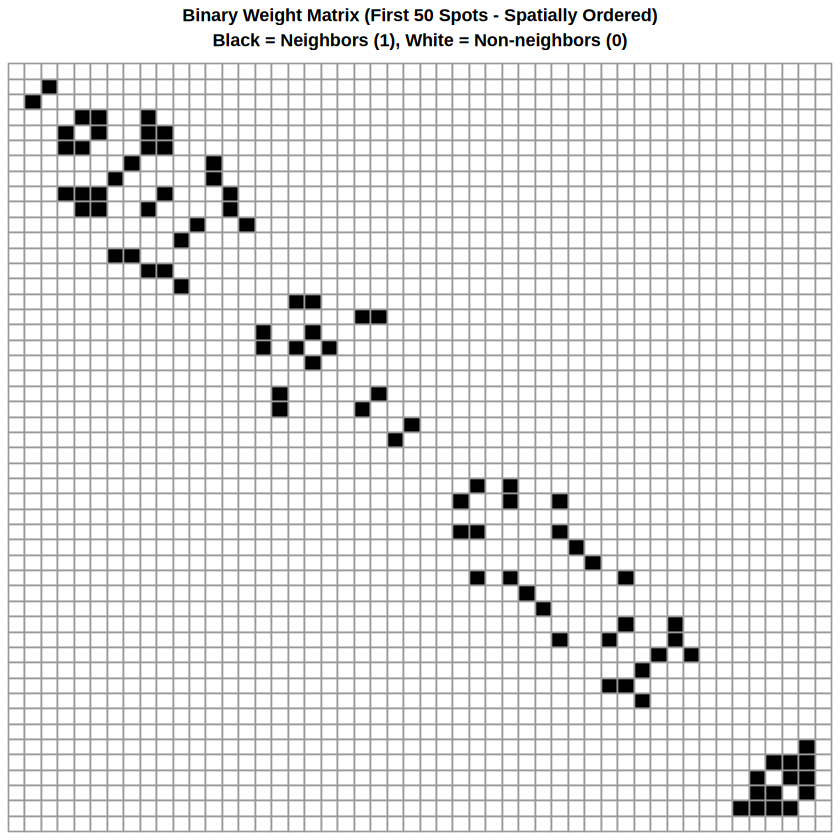

In [58]:
# Compute binary weight matrix based on spatial adjacency
# In Visium, neighboring spots are typically defined by distance threshold

# Calculate all pairwise distances
coords_subset <- spatial_coords[1:50, c("x", "y")]
dist_matrix_full <- as.matrix(dist(coords_subset))

# Check the distribution of distances to find appropriate threshold
print("Distance distribution summary:")
print(summary(as.vector(dist_matrix_full[dist_matrix_full > 0])))

# Find nearest neighbor distances
min_distances <- apply(dist_matrix_full + diag(Inf, nrow(dist_matrix_full)), 1, min)
print(paste("\nAverage nearest neighbor distance:", round(mean(min_distances), 2)))

# Use 1.5x the average nearest neighbor distance as threshold
threshold <- mean(min_distances) * 1.5
print(paste("Using threshold:", round(threshold, 2)))

# Create binary weight matrix (1 if neighbors, 0 otherwise)
weight_matrix <- ifelse(dist_matrix_full > 0 & dist_matrix_full <= threshold, 1, 0)

print(paste("\nNumber of spots:", nrow(coords_subset)))
print(paste("Average neighbors per spot:", round(mean(rowSums(weight_matrix)), 2)))
print("\nFirst 10x10 of binary weight matrix:")
print(weight_matrix[1:10, 1:10])

# Visualize the binary weight matrix as a heatmap
library(pheatmap)

# Order spots by spatial coordinates (left to right, then top to bottom)
# This makes the weight matrix easier to interpret
spatial_order <- order(coords_subset$x, coords_subset$y)
weight_matrix_ordered <- weight_matrix[spatial_order, spatial_order]

pheatmap(weight_matrix_ordered,
         color = c("white", "black"),
         main = "Binary Weight Matrix (First 50 Spots - Spatially Ordered)\nBlack = Neighbors (1), White = Non-neighbors (0)",
         cluster_rows = FALSE,
         cluster_cols = FALSE,
         show_rownames = FALSE,
         show_colnames = FALSE,
         legend = FALSE,
         fontsize = 8)

Warning message in dist(coords_matrix_50):
“NAs introduced by coercion”


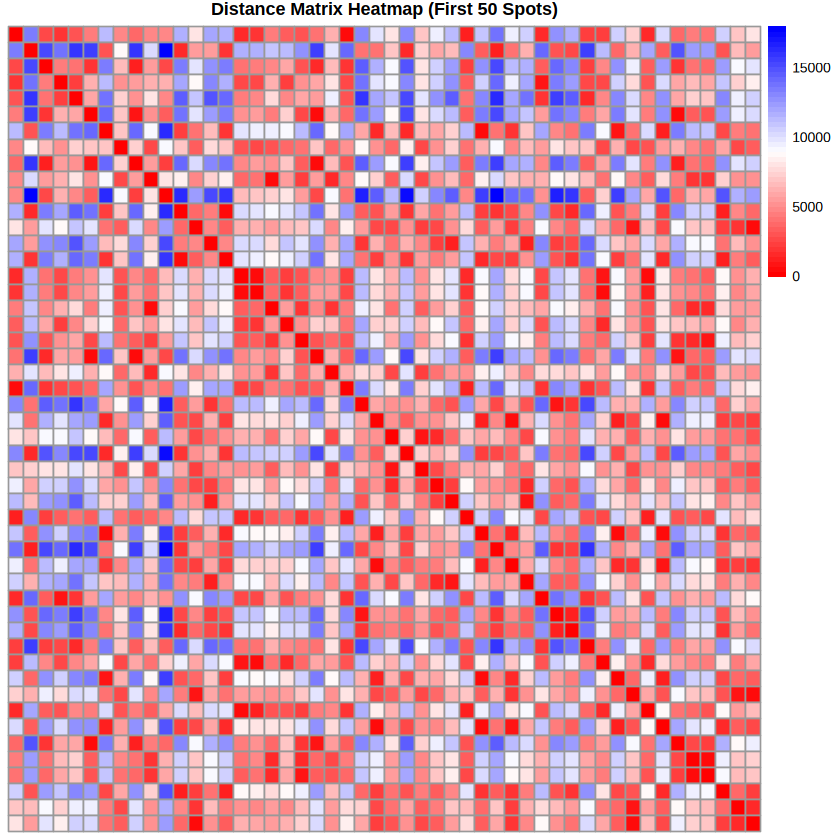

In [ ]:
# Additional visualization: show spatial connectivity network
# Plot the first 50 spots with connections between neighbors
library(ggplot2)
library(ggraph)
library(igraph)

# Create edge list from weight matrix
edges <- which(weight_matrix == 1, arr.ind = TRUE)
edges_df <- data.frame(from = edges[,1], to = edges[,2])

# Create igraph object
g <- graph_from_data_frame(edges_df, directed = FALSE, vertices = data.frame(id = 1:nrow(coords_subset)))

# Add coordinates to vertices
V(g)$x <- coords_subset$x
V(g)$y <- coords_subset$y

# Plot spatial network
ggraph(g, layout = "manual", x = V(g)$x, y = V(g)$y) +
  geom_edge_link(color = "gray70", alpha = 0.5) +
  geom_node_point(size = 3, color = "steelblue") +
  labs(title = "Spatial Neighborhood Network (First 50 Spots)",
       subtitle = "Edges connect neighboring spots based on weight matrix") +
  theme_void() +
  coord_fixed()

In [30]:
# Save filtered results (only genes with Moran's I statistics) to CSV
write.csv(moransi_results_filtered, file = "../data/spatial/results/moransi_results_filtered.csv", row.names = TRUE)
print(paste("Saved", nrow(moransi_results_filtered), "genes with Moran's I statistics to CSV"))

[1] "Saved 1000 genes with Moran's I statistics to CSV"


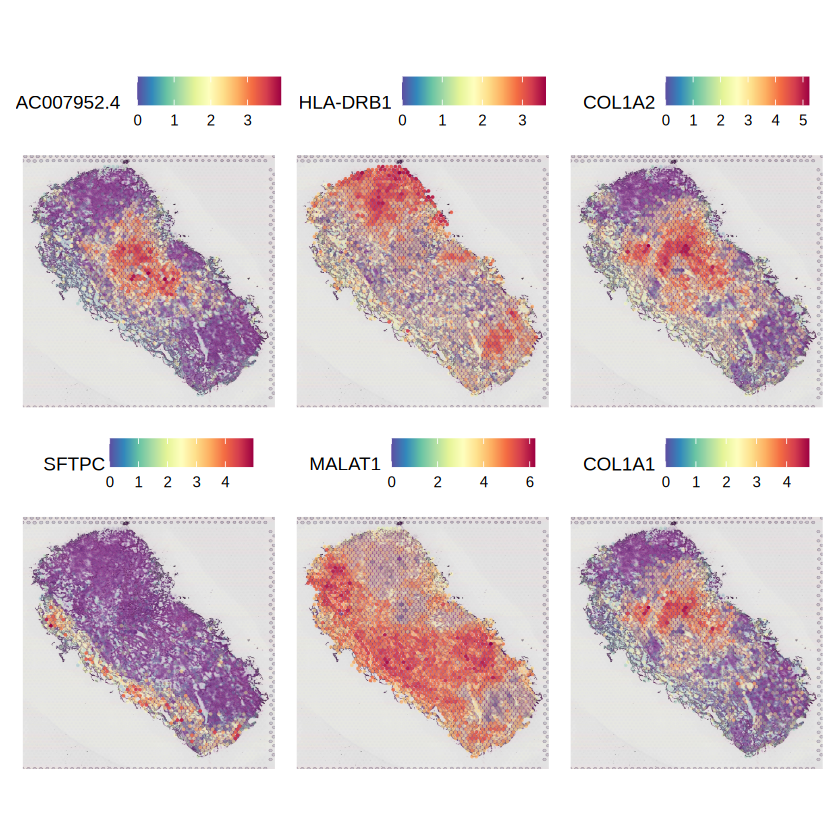

In [31]:
# Visualize top spatially variable features on tissue
SpatialFeaturePlot(visium_data, features = top_features, ncol = 3, alpha = c(0.1, 1))

## Save Processed Data

Save the preprocessed Seurat object for downstream analysis

In [ ]:
# Save processed Seurat object
saveRDS(visium_data, file = "../data/processed_counts/p10_t1_visium_processed.rds")